# A1: Data Curation Assignment
 
**Objective:** The goal of this assignment is to construct, analyze, and publish a dataset of monthly traffic on the English Wikipedia application from January 1, 2008 through August 30, 2021.

*Import the necessary libraries*

In [1]:
import json
import requests
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from pprint import pprint

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

*Defining endpoints and paths.*

In [2]:
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'
endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

#json data from legacy endpoints
pagecounts_desktop_outfile_path = "./data_raw/pagecounts_desktop-site_200712-201608.json"
pagecounts_mobile_outfile_path  = "./data_raw/pagecounts_mobile-site_200712-201608.json"

#json data from current endpoints
pageviews_desktop_outfile_path   = "./data_raw/pageviews_desktop_201507-202108.json"
pageviews_mobile_web_outfile_path = "./data_raw/pageviews_mobile-web_201507-202108.json"
pageviews_mobile_app_outfile_path = "./data_raw/pageviews_mobile-app_201507-202108.json"

# The output files.
csv_outfile_path = "./data_clean/en-wikipedia_traffic_200712-202108.csv"
png_outfile_path = "./data_clean/en-wikipedia_traffic_200712-202108.png"

In [3]:
#function for API endpoint call
def api_call(endpoint,parameters):
    """
    Takes the endpoint and input parameters to the endpoint to give us the traffic data.
    """
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    return response

## Step 1: Data acquisition

The source data is licensed under the [Creative Commons Attribution-ShareAlike License](https://creativecommons.org/licenses/by-sa/3.0/). 
  
The Wikimedia Foundation REST API terms of use are mentioned here, [Terms and Conditions](https://www.mediawiki.org/wiki/REST_API#Terms_and_conditions).

The relevant API documentation can be found in the following links:  
* The Legacy Pagecounts API ([documentation](https://wikitech.wikimedia.org/wiki/Analytics/AQS/Legacy_Pagecounts), [endpoint](https://wikimedia.org/api/rest_v1/#!/Pagecounts_data_(legacy)/get_metrics_legacy_pagecounts_aggregate_project_access_site_granularity_start_end)) provides access to desktop and mobile traffic data from December 2007 through July 2016.  
  
* The Pageviews API ([documentation](https://wikitech.wikimedia.org/wiki/Analytics/AQS/Pageviews), [endpoint](https://wikimedia.org/api/rest_v1/#!/Pageviews_data/get_metrics_pageviews_aggregate_project_access_agent_granularity_start_end)) provides access to desktop, mobile web, and mobile app traffic data from July 2015 through last month.
  

* Legacy Pagecounts API: https://wikitech.wikimedia.org/wiki/Analytics/AQS/Legacy_Pagecounts
* Modern Pageviews API: https://wikitech.wikimedia.org/wiki/Analytics/AQS/Pageviews
* Sample code for accessing the Wikipedia API was made available for re-use under a CC0 license: https://creativecommons.org/share-your-work/public-domain/cc0/

`Note`   
The more current Pageview API allows you to filter by agent=user which ensures that we get user traffic that is not by web crawlers or spiders. This type of traffic is more valuable to us. This is not the case in the legacy Pagecount API. Therefore, the final analysis of the legacy API might include bot and web crawler traffic.

In [4]:
#Set headers
headers = {
    'User-Agent': 'https://github.com/smuktevi',
    'From': 'vmuktev1@uw.edu'
}

*Example: The following is sample code that can be used to test if the endpoints and the `api_call` function are working as expected.*

In [5]:
# SAMPLE parameters for getting aggregated legacy view data 
# see: https://wikimedia.org/api/rest_v1/#!/Legacy_data/get_metrics_legacy_pagecounts_aggregate_project_access_site_granularity_start_end
example_params_legacy = {"project" : "en.wikipedia.org",
                 "access-site" : "desktop-site",
                 "granularity" : "monthly",
                 "start" : "2001010100",
                # for end use 1st day of month following final month of data
                 "end" : "2018100100"
                    }

# SAMPLE parameters for getting aggregated current standard pageview data
# see: https://wikimedia.org/api/rest_v1/#!/Pageviews_data/get_metrics_pageviews_aggregate_project_access_agent_granularity_start_end
example_params_pageviews = {"project" : "en.wikipedia.org",
                    "access" : "desktop",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2001010100",
                    # for end use 1st day of month following final month of data
                    "end" : '2018101000'
                        }

#EXAMPLES: Using the api_call function to get pageviews and pagecounts. Uncomment the following lines to use the samples.
# example_monthly_pageviews = api_call(endpoint_pageviews, example_params_pageviews)
# pprint(example_monthly_pageviews)

# example_monthly_legacy = api_call(endpoint_legacy, example_params_legacy)
# pprint(example_monthly_legacy)

*Set parameters for required API calls.*

In [6]:
params_legacy = {"project" : "en.wikipedia.org",
                 "access-site" : None,
                 "granularity" : "monthly",
                 "start" : "2007120100",
                 "end" : "2016080100"
                }
params_pageviews = {"project" : "en.wikipedia.org",
                    "access" : None,
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2015070100",
                    "end" : "2021090100"
                   }

*Get JSON data using API Endpoints and parameters with the `api_call` function, then store the resulting JSON files in the `raw` data directory.*
  
  
Naming convention of the json files will be based on the following templates:    
* legacy path: `./raw/pagecounts_{accesstype}_{start_date}-{end_date}.json`  
* pageviews path: `./raw/pageviews_{accesstype}_{start_date}-{end_date}.json`  

In [7]:
#from legacy
for access_site in ["desktop-site", "mobile-site"]:
    params_legacy["access-site"] = access_site
    json_data = api_call(endpoint_legacy, params_legacy)
    outfile_path = "./data_raw/pagecounts_{}_{}-{}.json".format(access_site, "20071201","20160801")
    with open(outfile_path, "w") as f:
        json.dump(json_data, f)
        
#from pageviews
for access in ["desktop", "mobile-app", "mobile-web"]:
    params_pageviews["access"] = access
    json_data = api_call(endpoint_pageviews, params_pageviews)
    outfile_path = "./data_raw/pageviews_{}_{}-{}.json".format(access, "20150701","20210801")
    with open(outfile_path, "w") as f:
        json.dump(json_data, f)

## Step 2: Data Processing

Next we need to load back the `json` data and process them into a final `csv` file.

*`json_data_process` will create Pandas DataFrames from json data and also formats the date into `YYYY` year and `MM` month format.*

In [8]:
def json_data_process(filename, json_data):
    data = pd.json_normalize(json_data, record_path="items")
    data["year"] = data.timestamp.apply(lambda s: s[:4])
    data["month"] = data.timestamp.apply(lambda s: s[4:6])
    return data

*We process the `json` data files into Pandas DataFrames using the function `json_data_processed` and combine all the files into one DataFrame object.*

In [9]:
directory = './data_raw/'
data = pd.DataFrame(columns = ['project', 'access-site', 'granularity', 'timestamp', 'count', 'year', 'month', "access", "agent", "views"])
for filename in os.listdir(directory):
    if filename.endswith(".json"):
        with open(directory+filename) as f:
            json_data = json.load(f)
            data = data.append(json_data_process(filename, json_data))
    else:
        continue
data

,project,access-site,granularity,timestamp,count,year,month,access,agent,views
0,en.wikipedia,mobile-site,monthly,2014100100,3091546685,2014,10,NaN,NaN,NaN
1,en.wikipedia,mobile-site,monthly,2014110100,3027489668,2014,11,NaN,NaN,NaN
2,en.wikipedia,mobile-site,monthly,2014120100,3278950021,2014,12,NaN,NaN,NaN
3,en.wikipedia,mobile-site,monthly,2015010100,3485302091,2015,01,NaN,NaN,NaN
4,en.wikipedia,mobile-site,monthly,2015020100,3091534479,2015,02,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
99,en.wikipedia,desktop-site,monthly,2016030100,5407676056,2016,03,NaN,NaN,NaN
100,en.wikipedia,desktop-site,monthly,2016040100,5572235399,2016,04,NaN,NaN,NaN
101,en.wikipedia,desktop-site,monthly,2016050100,5330532334,2016,05,NaN,NaN,NaN
102,en.wikipedia,desktop-site,monthly,2016060100,4975092447,2016,06,NaN,NaN,NaN


*We remove the unnecessary columns and transfer any important data to other fields that can be used.*

  
    
* *`count` and `views` mean the same thing so we combine these two columns.*

In [10]:
data['count'] = data['count'].combine_first(data['views'])
df = data.drop(columns=["project", "granularity", "timestamp", "agent", "views"])
new_df = df.copy()
new_df

,access-site,count,year,month,access
0,mobile-site,3091546685,2014,10,NaN
1,mobile-site,3027489668,2014,11,NaN
2,mobile-site,3278950021,2014,12,NaN
3,mobile-site,3485302091,2015,01,NaN
4,mobile-site,3091534479,2015,02,NaN
...,...,...,...,...,...
99,desktop-site,5407676056,2016,03,NaN
100,desktop-site,5572235399,2016,04,NaN
101,desktop-site,5330532334,2016,05,NaN
102,desktop-site,4975092447,2016,06,NaN


* *`mobile-app` and `mobile-web` are taken to mean the same thing so we rename `mobile-web` as `mobile-app`.*
* *`access` and `access-site` mean the same thing so we combine these two columns.*

In [11]:
new_df.access[new_df["access"]=="mobile-web"] = "mobile-app"
new_df.access[new_df["access"]=="mobile-app"] = "pageview_mobile_views"
new_df.access[new_df["access"]=="desktop"] = "pageview_desktop_views"

new_df["access-site"][new_df["access-site"]=="mobile-site"] = "pagecount_mobile_views"
new_df["access-site"][new_df["access-site"]=="desktop-site"] = "pagecount_desktop_views"
new_df['access-site'] = new_df['access-site'].combine_first(new_df['access'])

print(new_df["access-site"].value_counts())

pageview_mobile_views      148
pagecount_desktop_views    104
pageview_desktop_views      74
pagecount_mobile_views      22
Name: access-site, dtype: int64


*Finally we have only the required renamed `access-site` types which are renamed to reflect the API type and access type which is either `mobile` or `desktop`.*

*Then, we `groupby` the `access-site`, `year` and `month` to aggregate the sum total counts for each of these types per the given dates.*

In [12]:
final_df = new_df.drop(columns="access").groupby(by=["access-site","year", "month"], dropna=False).sum().reset_index()
final_df

,access-site,year,month,count
0,pagecount_desktop_views,2007,12,2998331524
1,pagecount_desktop_views,2008,01,4930902570
2,pagecount_desktop_views,2008,02,4818393763
3,pagecount_desktop_views,2008,03,4955405809
4,pagecount_desktop_views,2008,04,5159162183
...,...,...,...,...
269,pageview_mobile_views,2021,04,4759095083
270,pageview_mobile_views,2021,05,4976579558
271,pageview_mobile_views,2021,06,4584510417
272,pageview_mobile_views,2021,07,4778909421


*We pivot the column of access type to reflect the required table format of our target `output` csv file.*

In [13]:
pivot_df = final_df.pivot(columns='access-site', index = ['year', 'month'], values = "count").reset_index()
pivot_df

access-site,year,month,pagecount_desktop_views,pagecount_mobile_views,pageview_desktop_views,pageview_mobile_views
0,2007,12,2.998332e+09,NaN,NaN,NaN
1,2008,01,4.930903e+09,NaN,NaN,NaN
2,2008,02,4.818394e+09,NaN,NaN,NaN
3,2008,03,4.955406e+09,NaN,NaN,NaN
4,2008,04,5.159162e+09,NaN,NaN,NaN
...,...,...,...,...,...,...
160,2021,04,NaN,NaN,2.882714e+09,4.759095e+09
161,2021,05,NaN,NaN,2.824416e+09,4.976580e+09
162,2021,06,NaN,NaN,2.505971e+09,4.584510e+09
163,2021,07,NaN,NaN,2.765584e+09,4.778909e+09


*We create `time_df` storing the year and month of all the dates wihtin our time period under observation.* 

In [14]:
date_range_list = pd.date_range('2008-01-01','2021-12-01', freq='MS').strftime("%Y-%m").tolist()
time_df = pd.DataFrame({'time':date_range_list})
time_df['year'] = time_df['time'].apply(lambda s: s[:4])
time_df['month'] = time_df['time'].apply(lambda s: s[-2:])
time_df.drop(columns=['time'], inplace=True)
time_df

,year,month
0,2008,01
1,2008,02
2,2008,03
3,2008,04
4,2008,05
...,...,...
163,2021,08
164,2021,09
165,2021,10
166,2021,11


*We then do an outer join between this `time_df` and the pivoted dataframe `pivot_df` to account for filling in any missing dates.* 
  
*We also include the `all` views fields by adding the two `desktop` and `mobile` views feilds.*

In [15]:
merge_df = pd.merge(pivot_df, time_df, on=['year', 'month'], how="outer")
merge_df.fillna(0, inplace=True)
merge_df["pagecount_all_views"] = merge_df["pagecount_desktop_views"] + merge_df["pagecount_mobile_views"]
merge_df["pageview_all_views"] = merge_df["pageview_desktop_views"] + merge_df["pageview_mobile_views"]
result_df = merge_df.copy()
result_df

,year,month,pagecount_desktop_views,pagecount_mobile_views,pageview_desktop_views,pageview_mobile_views,pagecount_all_views,pageview_all_views
0,2007,12,2.998332e+09,0.0,0.000000e+00,0.000000e+00,2.998332e+09,0.000000e+00
1,2008,01,4.930903e+09,0.0,0.000000e+00,0.000000e+00,4.930903e+09,0.000000e+00
2,2008,02,4.818394e+09,0.0,0.000000e+00,0.000000e+00,4.818394e+09,0.000000e+00
3,2008,03,4.955406e+09,0.0,0.000000e+00,0.000000e+00,4.955406e+09,0.000000e+00
4,2008,04,5.159162e+09,0.0,0.000000e+00,0.000000e+00,5.159162e+09,0.000000e+00
...,...,...,...,...,...,...,...,...
164,2021,08,0.000000e+00,0.0,2.763414e+09,4.732194e+09,0.000000e+00,7.495608e+09
165,2021,09,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
166,2021,10,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
167,2021,11,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


*Here we rearrange the columns to make visualization easier.*

In [16]:
cols = list(result_df.columns.values)
cols

['year',
 'month',
 'pagecount_desktop_views',
 'pagecount_mobile_views',
 'pageview_desktop_views',
 'pageview_mobile_views',
 'pagecount_all_views',
 'pageview_all_views']

In [17]:
result_df_ = result_df[['year',
 'month', 
 'pagecount_all_views',
 'pagecount_desktop_views',
 'pagecount_mobile_views',
 'pageview_all_views',
 'pageview_desktop_views',
 'pageview_mobile_views']]
result_df_

,year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views
0,2007,12,2.998332e+09,2.998332e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
1,2008,01,4.930903e+09,4.930903e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
2,2008,02,4.818394e+09,4.818394e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
3,2008,03,4.955406e+09,4.955406e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
4,2008,04,5.159162e+09,5.159162e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...
164,2021,08,0.000000e+00,0.000000e+00,0.0,7.495608e+09,2.763414e+09,4.732194e+09
165,2021,09,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00
166,2021,10,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00
167,2021,11,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00


**The resulting dataframe is stored in a final data table named `en-wikipedia_traffic_200712-202108.csv`**

In [18]:
result_df_.to_csv("./data_clean/en-wikipedia_traffic_200712-202108.csv")

The following is the schema for the resulting data table.  

|Column | Value/Type | 
| --- | --- |
| year | YYYY |
| month | MM |
| pagecount_all_views | num_views |
| pagecount_desktop_views | num_views |
| pagecount_mobile_views | num_views |
| pageview_all_views | num_views |
| pageview_desktop_views | num_views |
| pageview_mobile_views | num_views |

## Step 3: Data Analysis

We will Visualize the resulting dataset as a time series graph.   

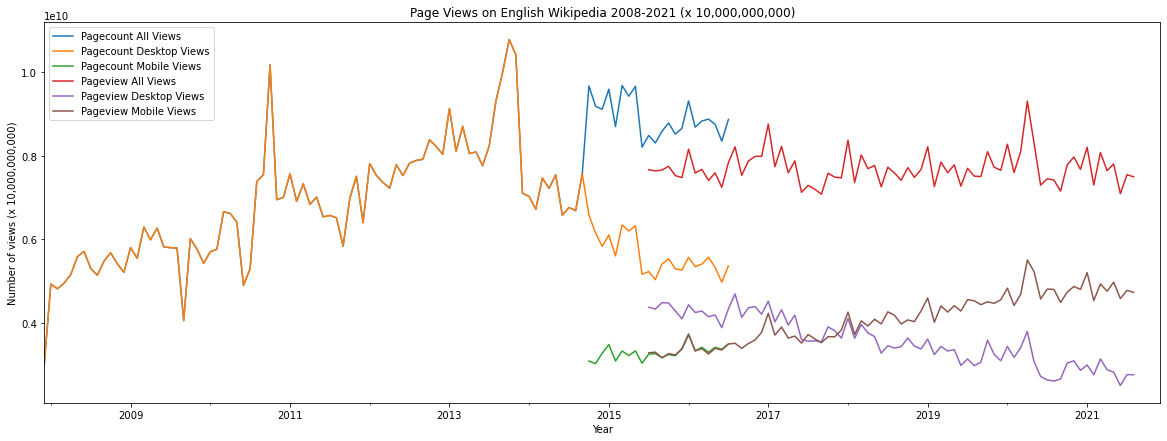

In [19]:
# Delete the last values in for pagecount
result_df_.replace(0, np.nan, inplace=True)

ax = result_df_.set_index(pd.to_datetime(result_df_[['year','month']].assign(day=1))).plot(figsize=(20,7))
ax.set_title("Page Views on English Wikipedia 2008-2021 (x 10,000,000,000)")
ax.set_xlabel("Year")
ax.set_ylabel("Number of views (x 10,000,000,000)")
plt.legend(["Pagecount All Views", "Pagecount Desktop Views", "Pagecount Mobile Views", 
            "Pageview All Views", "Pageview Desktop Views", "Pageview Mobile Views"])
plt.savefig('./results/en-wikipedia_traffic_200712-202108.jpg')
plt.show()

`Notes`  
  
* You can see that there is about a year of overlapping data between the two APIs between 2015 and 2017.
* The current Pageview API shows less noise compared to the legacy Pagecount API which might be the indication of the legacy API not accounting for the bot and web crawler traffic.